In [5]:
import numpy as np
from pathlib import Path
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold


## This part is for data preparation, after we have saved diff_result.csv, we can skip this part

In [11]:
# 读取Excel文件
# file_path = '../TE_analysefile_for_Tahereh_zijde.xlsx'
file_path = "../../data/TE_TreatmentResponse_cleanforJingnan.xlsx"

df = pd.read_excel(file_path)

# 移除 "SCANdatum" 和 "Scoredatum" 列
columns_to_remove = ['SCANdatum', 'Scoredatum', 'VISDATUM']
df = df.drop(columns=columns_to_remove)

remove_ls = [365, 387, 399, 458]  # these patients have no second scans

# 根据条件将 DataFrame 拆分为两个
condition = df['TENR'].isin(remove_ls)
df_no_second_scan = df[condition]
df = df[~condition]

placebo_df = df[df['treatment'] == 0]
df = df[df['treatment'] == 1]

# 提取所有有baseline的患者
baseline_df = df[df['VISNUMMER'] == 1]

# 提取所有有second的患者
second_df = df[df['VISNUMMER'] != 1]


In [18]:
# 合并两个数据框，基于ID进行对齐
merged_df = pd.merge(baseline_df, second_df, on='TENR', suffixes=('_baseline', '_12month'), how='inner').copy()

# 计算second的临床数据减去baseline的临床数据
result_df = merged_df.copy()
clinical_columns = [i for i in df.columns if 'tot' in i.lower()]  
clinical_columns_baseline = [i + '_baseline' for i in clinical_columns] #
clinical_columns_12month = [i + '_12month' for i in clinical_columns] #

# merged_df_clean = merged_df[clinical_columns_baseline + clinical_columns_12month]
# merged_df_clean.dropna()

for column in clinical_columns:
    merged_df[column + '_diff'] = merged_df[column + '_12month'] - merged_df[column + '_baseline']

# 选择需要保存的列
result_columns = ['TENR'] + clinical_columns_baseline + clinical_columns_12month + [column + '_diff' for column in clinical_columns]

# 保存结果为新的Excel文件
result_df = merged_df[result_columns].copy()
result_df.rename(columns={'TENR': 'ID'}, inplace=True)
result_df.dropna(inplace=True)
result_df.to_excel('../../data/diff_result_3.xlsx', index=False)
result_df.to_csv('../../data/diff_result_3.csv', index=False)

## This part is for data analysis

In [194]:
result_df = pd.read_csv('../../data/diff_result_3.csv')

In [144]:
split103_id = [  2,   3,   9,  11,  13,  15,  18,  22,  24,  37,  38,  43,  52,  56,  58,  60,  63,  74,
  83,  88,  89,  94,  99, 100, 107, 109, 116, 119, 127, 134, 137, 138, 144, 146, 149, 152,
 160, 166, 168, 171, 177, 192, 202, 209, 210, 223, 227, 228, 233, 235, 241, 247, 249, 254,
 256, 263, 267, 272, 274, 282, 285, 287, 290, 292, 295, 296, 313, 316, 325, 332, 342, 349,
 356, 357, 366, 370, 371, 373, 383, 384, 386, 389, 390, 400, 402, 405, 406, 410, 416, 421,
 425, 435, 437, 439, 441, 442, 454, 455, 456, 466, 479, 485, 487]  # temporary 103 patients
filtered_df = result_df[result_df['ID'].isin(split103_id)]
# current_folder = Path.cwd()
# split103_id = set()
# for i in range(10):
#     TRT_label = np.load(current_folder/f'../../data/split_103/label_train_round_0_fold_{i}.npy')
#     split103_id = split103_id | set(TRT_label)

In [195]:
filtered_df = result_df

In [196]:
# 提取 x 和 y 列
x = filtered_df['Tot_inflammation_baseline']
y = filtered_df['Tot_inflammation_diff']
slope, intercept, r_value, p_value, std_err = linregress(x, y) # 计算线性回归
filtered_df['Tot_inflammation_diff_pred'] = slope * x + intercept  # 计算预测值
R = np.corrcoef(x, y)[0, 1]  # 计算皮尔逊相关系数



In [177]:
# 打印结果
print("线性拟合方程：y = {:.2f}x + {:.2f}".format(slope, intercept))
print("皮尔逊相关系数 R：{:.2f}".format(R))
print(filtered_df[['Tot_inflammation_baseline', 'Tot_inflammation_diff', 'Tot_inflammation_diff_pred']])

线性拟合方程：y = -0.59x + 2.42
皮尔逊相关系数 R：-0.65
     Tot_inflammation_baseline  Tot_inflammation_diff  \
0                          2.0                   -1.0   
1                         11.0                   -1.0   
2                          2.5                    2.0   
3                          7.0                   -2.5   
4                         11.0                   -3.5   
..                         ...                    ...   
110                        3.0                    0.0   
111                        1.0                    6.5   
112                        4.5                    6.0   
113                        4.0                    6.5   
114                        4.0                   -1.0   

     Tot_inflammation_diff_pred  
0                      1.248857  
1                     -4.032512  
2                      0.955447  
3                     -1.685237  
4                     -4.032512  
..                          ...  
110                    0.662038  
11

混淆矩阵：
 [[17 11]
 [ 9 78]]


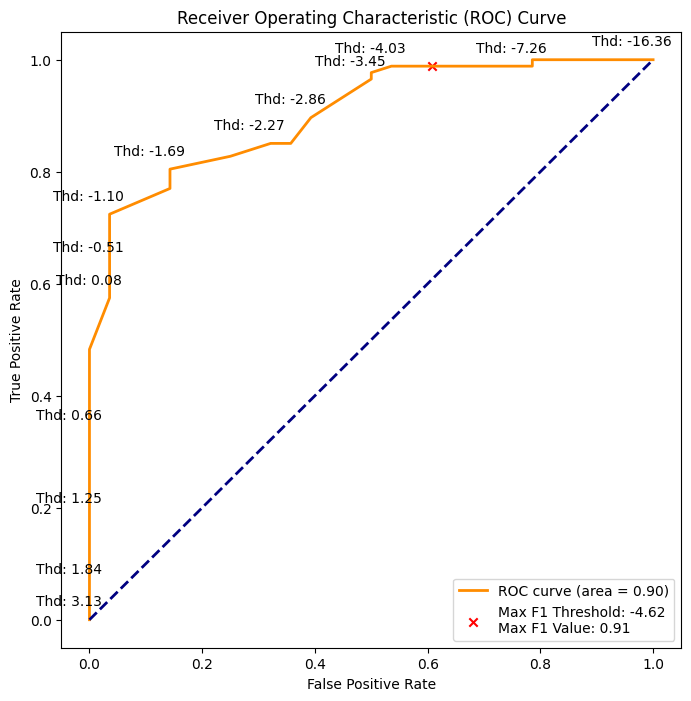

AUC 值：0.90


In [197]:
# 1. 创建 Tot_inflammation_baseline_bin 列
threshold_baseline = -3.12
filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)

# 2. 创建 Tot_inflammation_pred_bin 列
threshold_pred = -3.12
filtered_df['Tot_inflammation_diff_pred_bin'] = np.where(filtered_df['Tot_inflammation_diff_pred'] < threshold_pred, 0, 1)

# 3. 计算混淆矩阵
conf_matrix_baseline = confusion_matrix(filtered_df['Tot_inflammation_diff_bin'], filtered_df['Tot_inflammation_diff_pred_bin'])
print("混淆矩阵：\n", conf_matrix_baseline)

# 4. 计算 ROC 曲线和 AUC 值
fpr, tpr, thresholds = roc_curve(filtered_df['Tot_inflammation_diff_bin'], filtered_df['Tot_inflammation_diff_pred'])
roc_auc = auc(fpr, tpr)

# 找到最大 F1 值对应的 threshold
f1_values = [f1_score(filtered_df['Tot_inflammation_diff_bin'], filtered_df['Tot_inflammation_diff_pred'] > t) for t in thresholds]
max_f1_index = np.argmax(f1_values)
max_f1_threshold = thresholds[max_f1_index]
max_f1_value = f1_values[max_f1_index]


# 绘制 ROC 曲线
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# 标注部分点对应的 threshold
for i in range(0, len(thresholds), len(thresholds) // 10):
    plt.annotate(f'Thd: {thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(-15, 10), ha='center')

# 标注最大 F1 值对应的 threshold 和 F1 值
plt.scatter(fpr[max_f1_index], tpr[max_f1_index], c='red', marker='x', label=f'Max F1 Threshold: {max_f1_threshold:.2f}\nMax F1 Value: {max_f1_value:.2f}')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 打印 AUC 值
print("AUC 值：{:.2f}".format(roc_auc))

In [198]:
filtered_df

,ID,SDC_Total_baseline,Tot_BME_baseline,Tot_SYN_baseline,Tot_TS_baseline,total_ero_baseline,Tot_inflammation_baseline,tot_ramris_baseline,ERO_MCP2.gem_TOT_baseline,ERO_MCP3.gem_TOT_baseline,...,BME_MCP4.gem_TOT_diff,BME_MCP5.gem_TOT_diff,BME_MTP1.gem_TOT_diff,BME_MTP2.gem_TOT_diff,BME_MTP3.gem_TOT_diff,BME_MTP4.gem_TOT_diff,BME_MTP5.gem_TOT_diff,Tot_inflammation_diff_pred,Tot_inflammation_diff_bin,Tot_inflammation_diff_pred_bin
0,2,-3.067831,2.0,0.0,0.0,1.5,2.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.248857,1,1
1,3,-3.067831,0.0,2.0,9.0,2.0,11.0,13.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.032512,1,0
2,9,-3.067831,1.0,1.5,0.0,1.0,2.5,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.955447,1,1
3,11,-3.067831,1.5,4.0,1.5,0.5,7.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.685237,1,1
4,13,-3.067831,2.5,4.5,4.0,4.0,11.0,15.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.5,0.0,-4.032512,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,466,-3.067831,3.0,0.0,0.0,2.0,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.662038,1,1
111,479,-3.067831,0.0,1.0,0.0,3.0,1.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.835675,1,1
112,484,-3.067831,1.5,3.0,0.0,4.5,4.5,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.218190,1,1
113,485,-3.067831,0.5,2.5,1.0,2.0,4.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075219,1,1


------fold 0----
slope_train: -0.46, intercept_train: 1.72, r_value_train: -0.57
----start training ... ----
(76,) (76,)
confusion_matrix [[ 7  7]
 [ 3 59]]
ROC AUC 值：0.88，最大 F1 值：0.92 (对应的 Threshold：-3.12)
----end training ... ----
(39,) (39,)
confusion_matrix [[ 7  7]
 [ 0 25]]
测试集上，ROC AUC 值：0.95，最大 F1 值：0.88 (对应的 Threshold：-3.12)
x_cross_value = 10.455962428481795


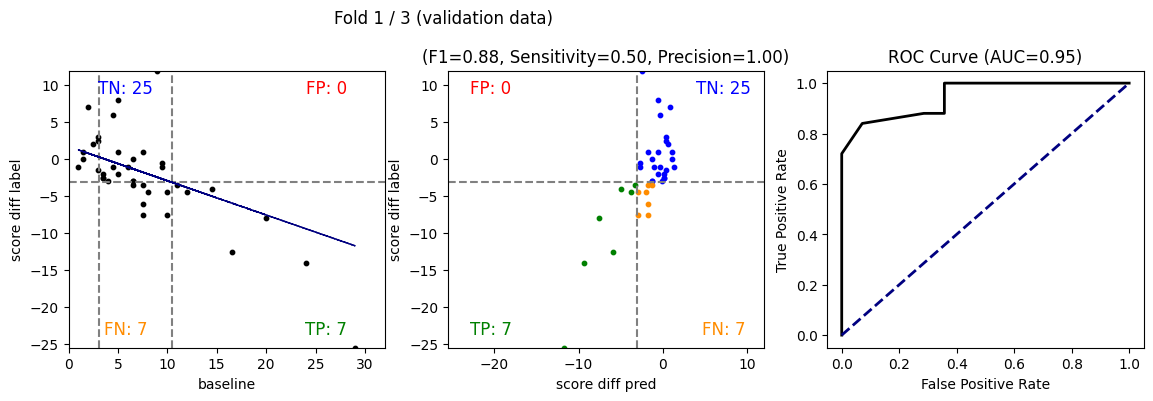

------fold 1----
slope_train: -0.78, intercept_train: 3.65, r_value_train: -0.76
----start training ... ----
(77,) (77,)
confusion_matrix [[13  7]
 [10 47]]
ROC AUC 值：0.90，最大 F1 值：0.85 (对应的 Threshold：-3.12)
----end training ... ----
(38,) (38,)
confusion_matrix [[ 5  3]
 [ 3 27]]
测试集上，ROC AUC 值：0.92，最大 F1 值：0.90 (对应的 Threshold：-3.12)
x_cross_value = 8.634296351812006


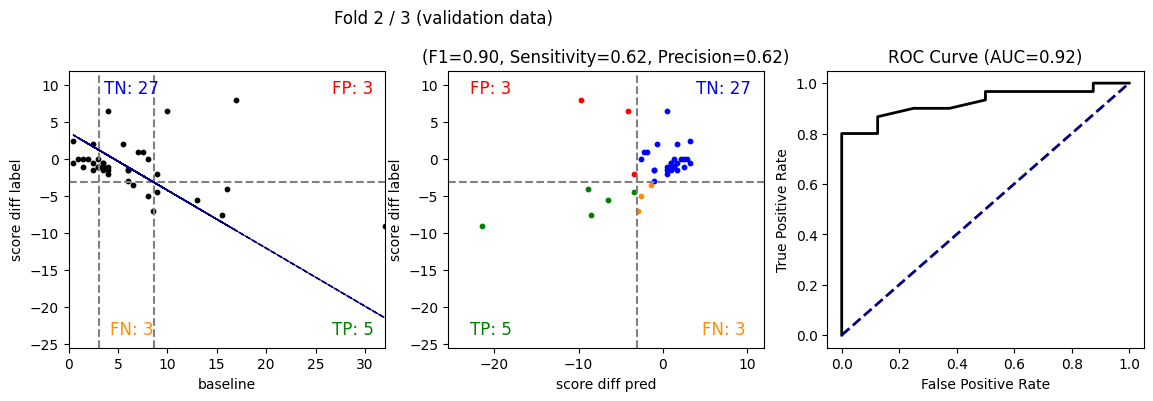

------fold 2----
slope_train: -0.52, intercept_train: 2.00, r_value_train: -0.61
----start training ... ----
(77,) (77,)
confusion_matrix [[13  9]
 [ 2 53]]
ROC AUC 值：0.93，最大 F1 值：0.91 (对应的 Threshold：-3.12)
----end training ... ----
(38,) (38,)
confusion_matrix [[ 3  3]
 [ 5 27]]
测试集上，ROC AUC 值：0.84，最大 F1 值：0.87 (对应的 Threshold：-3.12)
x_cross_value = 9.916422549813117


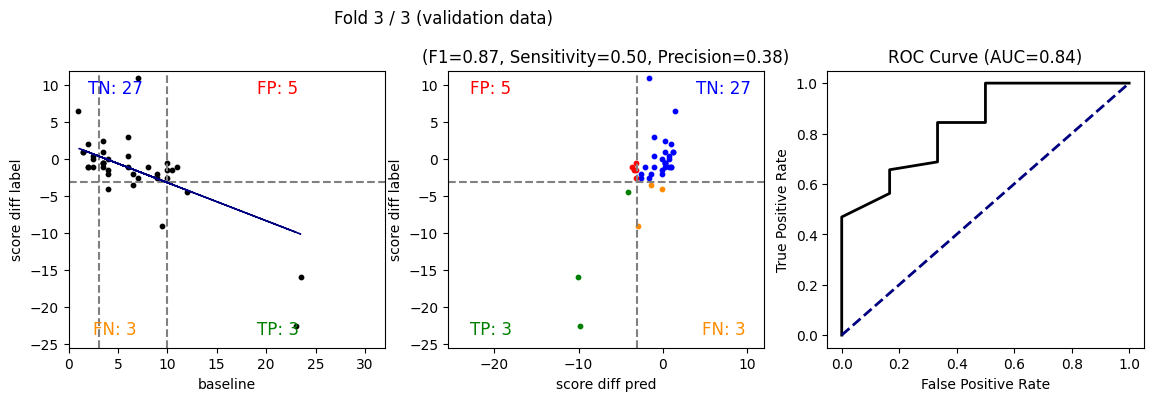

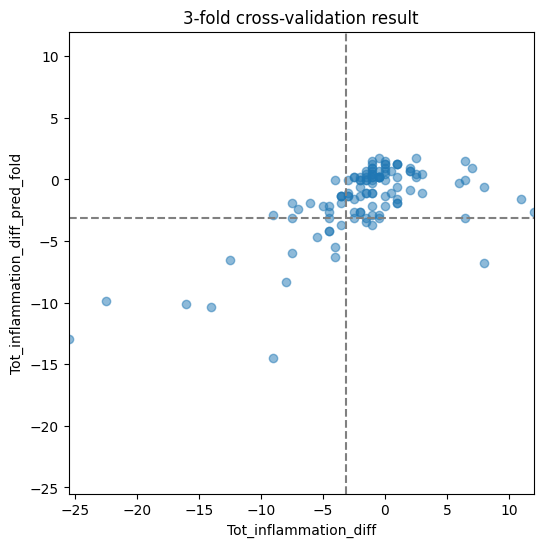


Mean AUC: 0.90
Mean F1: 0.88
Mean sensitivity: 0.54
Mean precision: 0.67


In [199]:
# 创建 Tot_inflammation_baseline_bin 列
threshold_baseline = -3.12
filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)

# 新增一列用于存储预测值
filtered_df['Tot_inflammation_diff_pred_fold'] = np.nan

# 分成4折
folds = 3
kf = KFold(n_splits=folds, shuffle=True, random_state=711)

# 存储每折的结果
roc_auc_list = []
roc_auc_list_train = []
max_f1_values = []
max_f1_values_train = []
sensitivity_ls = []
precision_ls = []

for fold, (train_index, test_index) in enumerate(kf.split(filtered_df)):
    print(f"------fold {fold}----")
    train_data = filtered_df.iloc[train_index]
    test_data = filtered_df.iloc[test_index]

    # 训练模型（使用线性回归，你也可以替换为其他模型）
    x_train = train_data['Tot_inflammation_baseline']
    y_train = train_data['Tot_inflammation_diff']
    # print(x_train.shape, y_train.shape)
  
    
    model = np.polyfit(x_train.squeeze(), y_train, 1)
    slope, intercept, r_value, p_value, std_err = linregress(x_train, y_train) # 计算线性回归
    slope2 = model[0]
    intercept2 = model[1]
    print(f'slope_train: {slope:.2f}, intercept_train: {intercept:.2f}, r_value_train: {r_value:.2f}')

    # 在训练集上进行预测
    print('----start training ... ----')
    print(x_train.shape, y_train.shape)

    y_pred_train = np.polyval(model, x_train.squeeze())
    # 保存预测值到 result_df 中
    filtered_df.iloc[train_index, filtered_df.columns.get_loc('Tot_inflammation_diff_pred_fold')] = y_pred_train

    # 计算 ROC 曲线和 AUC 值
    fpr, tpr, thresholds = roc_curve(train_data['Tot_inflammation_diff_bin'], y_pred_train)
    roc_auc = auc(fpr, tpr)
    roc_auc_list_train.append(roc_auc)


    matrix = confusion_matrix(train_data['Tot_inflammation_diff_bin'], y_pred_train > threshold_baseline)
    print('confusion_matrix', matrix)
    f1= f1_score(train_data['Tot_inflammation_diff_bin'], y_pred_train > threshold_baseline)
    max_f1_values_train.append(f1)

    # 打印每折的结果
    print("ROC AUC 值：{:.2f}，最大 F1 值：{:.2f} (对应的 Threshold：{:.2f})".format(roc_auc, f1, threshold_baseline))
    print('----end training ... ----')

    
    
    # 在测试集上进行预测

    x_test = test_data[['Tot_inflammation_baseline']].squeeze()
    y_test = test_data['Tot_inflammation_diff']
    
    print(x_test.shape, y_test.shape)
    # slope, intercept, r_value, p_value, std_err = linregress(x_test, y_test) # 计算线性回归
    # print('slope_test, intercept_test, r_value_test', slope, intercept, r_value)


    y_pred_test = np.polyval(model, x_test.squeeze())
    # 保存预测值到 result_df 中
    # filtered_df.loc[test_index, 'Tot_inflammation_diff_pred_fold'] = y_pred
    filtered_df.iloc[test_index, filtered_df.columns.get_loc('Tot_inflammation_diff_pred_fold')] = y_pred_test

    # 计算 ROC 曲线和 AUC 值
    fpr, tpr, thresholds = roc_curve(test_data['Tot_inflammation_diff_bin'], y_pred_test)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    # 找到最大 F1 值对应的 threshold
    # f1_values = [f1_score(test_data['Tot_inflammation_diff_bin'], y_pred > t) for t in thresholds]
    # max_f1_index = np.argmax(f1_values)
    # max_f1_value = f1_values[max_f1_index]
    # max_f1_threshold = thresholds[max_f1_index]
    matrix = confusion_matrix(test_data['Tot_inflammation_diff_bin'], y_pred_test > threshold_baseline)
    print('confusion_matrix', matrix)

    f1= f1_score(test_data['Tot_inflammation_diff_bin'], y_pred_test > threshold_baseline)
    max_f1_values.append(f1)

    # 打印每折的结果
    print("测试集上，ROC AUC 值：{:.2f}，最大 F1 值：{:.2f} (对应的 Threshold：{:.2f})".format(roc_auc, f1, threshold_baseline))
    
    
    
        # 绘制 预测散点图
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.6))
    ax1.scatter(x_test, y_test, color='black', s=10)
    # print(x_test.to_numpy())
    # print('---')
    # print(y_pred)
    # break
    min_idx = np.argmin(x_test.to_numpy())
    max_idx = np.argmax(x_test.to_numpy())
    ax1.set_xlabel('baseline')
    ax1.set_ylabel('score diff label')
    ax1.set_xlim(0, max(filtered_df['Tot_inflammation_baseline']))
    ax1.set_ylim(min(filtered_df['Tot_inflammation_diff']), max(filtered_df['Tot_inflammation_diff']))
    ax1.axhline(y=threshold_baseline, color='grey', linestyle='--', label='y = -3.12')
    ax1.plot([x_test.to_numpy()[min_idx], x_test.to_numpy()[max_idx]], [y_pred_test[min_idx], y_pred_test[max_idx]], color='navy', lw=1, linestyle='--')
    x_cross_value = (threshold_baseline - intercept)/slope
    print(f"x_cross_value = {x_cross_value}")
    ax1.axvline(x=x_cross_value, color='grey', linestyle='--', label=f'y = {x_cross_value}')
    ax1.axvline(x=-threshold_baseline, color='grey', linestyle='--', label=f'y = {threshold_baseline}')


    ax1.plot(x_test.to_numpy(), x_test.to_numpy() * slope + intercept, color='navy', lw=1, linestyle='--')

    # scatter = ax2.scatter(y_pred, y_test, color='blue', s=10)
    # 绘制横线y=-3.12
    ax2.axhline(y=threshold_baseline, color='grey', linestyle='--', label='y = -3.12')
    # 绘制竖线x=-3.12
    ax2.axvline(x=threshold_baseline, color='grey', linestyle='--', label='x = -3.12')

    # ax2.yaxis.set_label_position('right')
    ax2.set_ylabel('score diff label')
    ax2.set_xlabel('score diff pred')  
    
    # 获取x轴和y轴的最大最小值
    xy_min, xy_max = min(filtered_df['Tot_inflammation_diff']), max(filtered_df['Tot_inflammation_diff'])


    # 设置x轴和y轴的最大最小值一致
    ax2.set_xlim(xy_min, xy_max)
    ax2.set_ylim(xy_min, xy_max)
    # plt.show()
    # ax1.set_ylim(xy_min, xy_max, ) # subfiture 1 should have the same scale with subfigure 2 along the y axis



    # 划分四个区域的数据点
    TN_data = (y_pred_test > threshold_baseline) & (y_test > threshold_baseline)
    FP_data = (y_pred_test < threshold_baseline) & (y_test > threshold_baseline)
    FN_data = (y_pred_test > threshold_baseline) & (y_test < threshold_baseline)
    TP_data = (y_pred_test < threshold_baseline) & (y_test < threshold_baseline)

    # 统计每个区域的数据点个数
    TN = sum(TN_data)
    FN = sum(FN_data)
    FP = sum(FP_data)
    TP = sum(TP_data)
    
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    sensitivity_ls.append(sensitivity)
    precision_ls.append(precision)
    
    # 在图中标注每个区域的数据点个数
    ax2.text(xy_max * 0.6, xy_max * 0.8, f'TN: {TN}', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(xy_min * 0.8, xy_max * 0.8, f'FP: {FP}', ha='center', va='center', fontsize=12, color='red')
    ax2.text(xy_max * 0.6, xy_min * 0.9, f'FN: {FN}', ha='center', va='center', fontsize=12, color='darkorange')
    ax2.text(xy_min * 0.8, xy_min * 0.9, f'TP: {TP}', ha='center', va='center', fontsize=12, color='green')

    x_baseline_min = 0
    x_baseline_max = max(x_test)
    ax1.text(x_baseline_max * 0.9, xy_max * 0.8, f'FP: {FP}', ha='center', va='center', fontsize=12, color='red')
    ax1.text(x_baseline_max * 0.2, xy_max * 0.8, f'TN: {TN}', ha='center', va='center', fontsize=12, color='blue')
    ax1.text(x_baseline_max * 0.9, xy_min * 0.9, f'TP: {TP}', ha='center', va='center', fontsize=12, color='green')
    ax1.text(x_baseline_max * 0.2, xy_min * 0.9, f'FN: {FN}', ha='center', va='center', fontsize=12, color='darkorange')

    # ax2.text(xy_min * 0.6, xy_max * 0.6, f'F1={f1:.2f}', ha='center', va='center', fontsize=12, color='black')
    ax2.set_title(f'(F1={f1:.2f}, Sensitivity={sensitivity:.2f}, Precision={precision:.2f})')

    # 在散点图中分别绘制四个区域的数据点，并使用不同颜色
    ax2.scatter(y_pred_test[TN_data], y_test[TN_data], color='blue', s=10, label='Top Right')
    ax2.scatter(y_pred_test[FN_data], y_test[FN_data], color='darkorange', s=10, label='Top Left')
    ax2.scatter(y_pred_test[FP_data], y_test[FP_data], color='red', s=10, label='Bottom Right')
    ax2.scatter(y_pred_test[TP_data], y_test[TP_data], color='green', s=10, label='Bottom Left')


    # 绘制 ROC 曲线
    # plt.figure(figsize=(2, 2))
    ax3.plot(fpr, tpr, color='black', lw=2, label='(area = {:.2f})'.format(roc_auc))
    # ax3.text(max(fpr) * 0.8, min(tpr) * 0.9, f'AUC={roc_auc:.2f}', ha='center', va='center', fontsize=12, color='black')

    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlabel('False Positive Rate')
    # ax3.yaxis.set_label_position('right')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title(f'ROC Curve (AUC={roc_auc:.2f})')
    plt.subplots_adjust(right=1.2)

    # plt.legend(loc='lower right')
    plt.suptitle(f'Fold {fold+1} / {folds} (validation data)', y=1.05)
    plt.show()

# 绘制散点图和回归线
plt.figure(figsize=(6, 6))
plt.scatter(filtered_df['Tot_inflammation_diff'], filtered_df['Tot_inflammation_diff_pred_fold'], label='实际值', alpha=0.5)
# 绘制横线y=-3.12
plt.axhline(y=threshold_baseline, color='grey', linestyle='--', label='y = -3.12')

# 绘制竖线x=-3.12
plt.axvline(x=threshold_baseline, color='grey', linestyle='--', label='x = -3.12')


# plt.scatter(filtered_df['Tot_inflammation_baseline'], filtered_df['Tot_inflammation_diff_pred_fold'], label='预测值', alpha=0.5)
# plt.plot(filtered_df['Tot_inflammation_baseline'], filtered_df['Tot_inflammation_diff_pred_fold'], label='回归线', color='red', linewidth=2)
plt.xlabel('Tot_inflammation_diff')
plt.ylabel('Tot_inflammation_diff_pred_fold')
plt.title(f'{folds}-fold cross-validation result')
# plt.legend()
# 设置 x 和 y 轴上下限相同
max_limit = max(filtered_df['Tot_inflammation_diff'].max(), filtered_df['Tot_inflammation_diff_pred_fold'].max())
min_limit = min(filtered_df['Tot_inflammation_diff'].min(), filtered_df['Tot_inflammation_diff_pred_fold'].min())
plt.xlim(min_limit, max_limit)
plt.ylim(min_limit, max_limit)
plt.show()

# 打印平均结果
print("\nMean AUC: {:.2f}".format(np.mean(roc_auc_list)))
print("Mean F1: {:.2f}".format(np.mean(max_f1_values)))
print(f"Mean sensitivity: {np.mean(sensitivity_ls):.2f}")
print(f"Mean precision: {np.mean(precision_ls):.2f}")


In [190]:
# remove the patients with baseline score lower than 3.17

filtered_df = filtered_df[filtered_df['Tot_inflammation_baseline'] > -threshold_baseline]

In [191]:
filtered_df

,ID,SDC_Total_baseline,Tot_BME_baseline,Tot_SYN_baseline,Tot_TS_baseline,total_ero_baseline,Tot_inflammation_baseline,tot_ramris_baseline,ERO_MCP2.gem_TOT_baseline,ERO_MCP3.gem_TOT_baseline,...,BME_MCP5.gem_TOT_diff,BME_MTP1.gem_TOT_diff,BME_MTP2.gem_TOT_diff,BME_MTP3.gem_TOT_diff,BME_MTP4.gem_TOT_diff,BME_MTP5.gem_TOT_diff,Tot_inflammation_diff_bin,Tot_inflammation_diff_pred,Tot_inflammation_diff_pred_bin,Tot_inflammation_diff_pred_fold
1,3,-3.067831,0.0,2.0,9.0,2.0,11.0,13.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,-4.032512,0,-3.678931
3,11,-3.067831,1.5,4.0,1.5,0.5,7.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,-1.685237,1,-1.615650
4,13,-3.067831,2.5,4.5,4.0,4.0,11.0,15.0,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.5,0.0,0,-4.032512,0,-3.678931
6,18,-3.067831,0.5,5.5,2.5,3.5,8.5,12.0,0.0,2.0,...,0.0,-0.5,0.0,0.0,0.0,0.0,0,-2.565465,1,-2.389381
7,22,-3.067831,1.0,3.0,3.0,0.0,7.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.5,1,-1.685237,1,-1.615650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,455,-3.067831,3.5,5.0,7.0,4.0,15.5,19.5,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-6.673197,0,-6.000122
109,456,-3.067831,3.5,1.5,2.0,5.0,7.0,12.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,-1.685237,1,-1.615650
112,484,-3.067831,1.5,3.0,0.0,4.5,4.5,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.218190,1,-0.326100
113,485,-3.067831,0.5,2.5,1.0,2.0,4.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.075219,1,-0.068190


/tmp/ipykernel_109010/3823766621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)
/tmp/ipykernel_109010/3823766621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tot_inflammation_diff_pred_fold'] = np.nan
/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

------fold 0----
slope_train: -0.63, intercept_train: 2.78, r_value_train: -0.61
----start training ... ----
(57,) (57,)
confusion_matrix [[10  9]
 [ 8 30]]
ROC AUC 值：0.80，最大 F1 值：0.78 (对应的 Threshold：-3.12)
----end training ... ----
(29,) (29,)
confusion_matrix [[ 7  2]
 [ 1 19]]
测试集上，ROC AUC 值：0.96，最大 F1 值：0.93 (对应的 Threshold：-3.12)
x_cross_value = 9.41920795730228


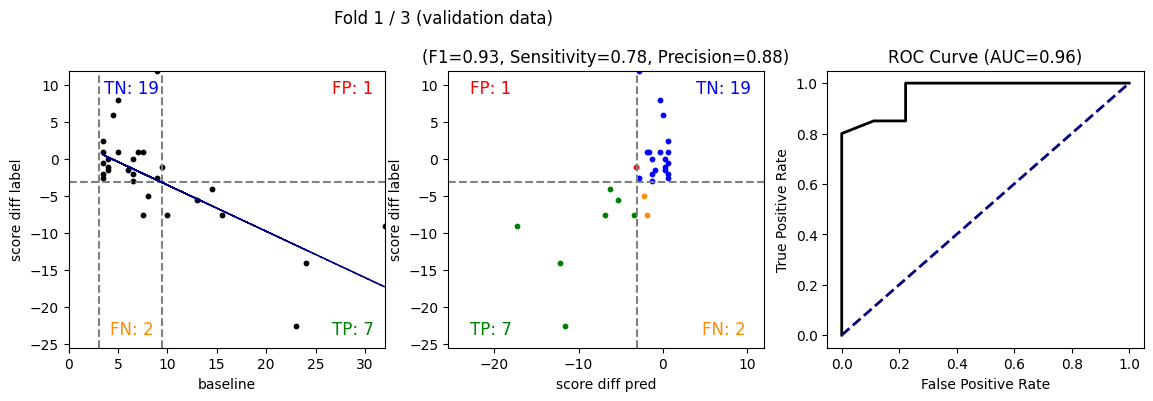

------fold 1----
slope_train: -0.72, intercept_train: 4.19, r_value_train: -0.71
----start training ... ----
(57,) (57,)
confusion_matrix [[11  5]
 [ 1 40]]
ROC AUC 值：0.90，最大 F1 值：0.93 (对应的 Threshold：-3.12)
----end training ... ----
(29,) (29,)
confusion_matrix [[ 3  9]
 [ 2 15]]
测试集上，ROC AUC 值：0.84，最大 F1 值：0.73 (对应的 Threshold：-3.12)
x_cross_value = 10.174909853996313


/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


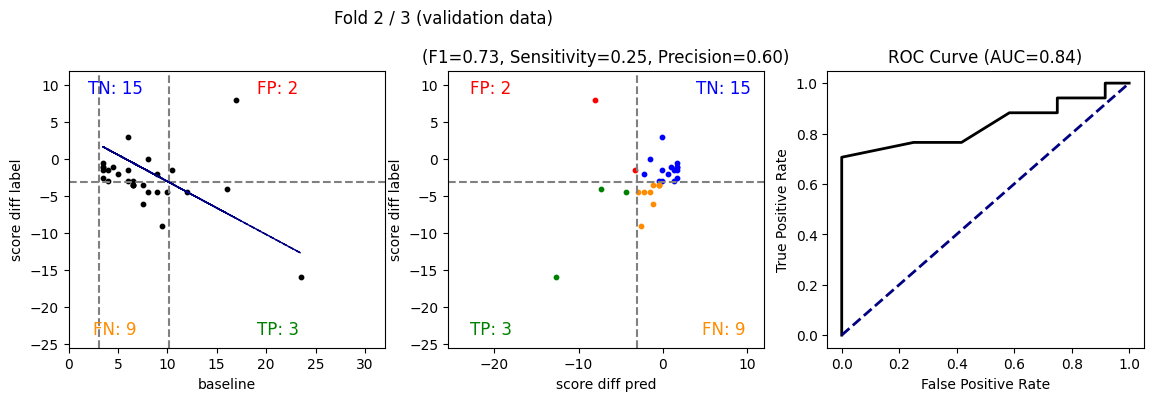

------fold 2----
slope_train: -0.53, intercept_train: 1.84, r_value_train: -0.59
----start training ... ----
(58,) (58,)
confusion_matrix [[12  9]
 [ 3 34]]
ROC AUC 值：0.89，最大 F1 值：0.85 (对应的 Threshold：-3.12)
----end training ... ----
(28,) (28,)
confusion_matrix [[ 5  2]
 [ 6 15]]
测试集上，ROC AUC 值：0.84，最大 F1 值：0.79 (对应的 Threshold：-3.12)
x_cross_value = 9.43622886507489


/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


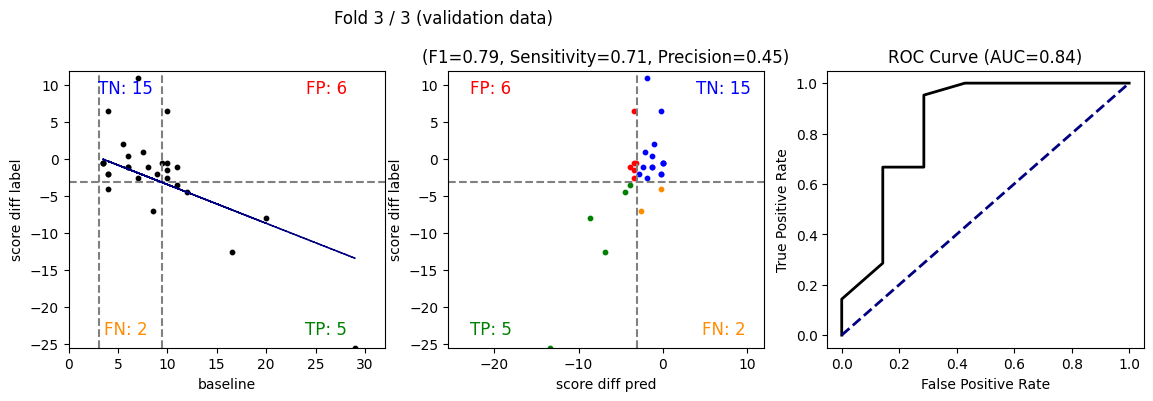

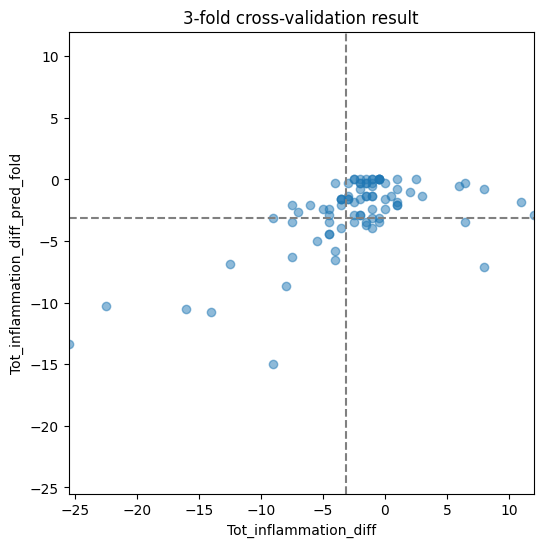


Mean AUC: 0.88
Mean F1: 0.82
Mean sensitivity: 0.58
Mean precision: 0.64


In [193]:
# 创建 Tot_inflammation_baseline_bin 列
threshold_baseline = -3.12
filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)

# 新增一列用于存储预测值
filtered_df['Tot_inflammation_diff_pred_fold'] = np.nan

# 分成4折
folds = 3
kf = KFold(n_splits=folds, shuffle=True, random_state=711)

# 存储每折的结果
roc_auc_list = []
roc_auc_list_train = []
max_f1_values = []
max_f1_values_train = []
sensitivity_ls = []
precision_ls = []

for fold, (train_index, test_index) in enumerate(kf.split(filtered_df)):
    print(f"------fold {fold}----")
    train_data = filtered_df.iloc[train_index]
    test_data = filtered_df.iloc[test_index]

    # 训练模型（使用线性回归，你也可以替换为其他模型）
    x_train = train_data['Tot_inflammation_baseline']
    y_train = train_data['Tot_inflammation_diff']
    # print(x_train.shape, y_train.shape)
  
    
    model = np.polyfit(x_train.squeeze(), y_train, 1)
    slope, intercept, r_value, p_value, std_err = linregress(x_train, y_train) # 计算线性回归
    slope2 = model[0]
    intercept2 = model[1]
    print(f'slope_train: {slope:.2f}, intercept_train: {intercept:.2f}, r_value_train: {r_value:.2f}')

    # 在训练集上进行预测
    print('----start training ... ----')
    print(x_train.shape, y_train.shape)

    y_pred_train = np.polyval(model, x_train.squeeze())
    # 保存预测值到 result_df 中
    filtered_df.iloc[train_index, filtered_df.columns.get_loc('Tot_inflammation_diff_pred_fold')] = y_pred_train

    # 计算 ROC 曲线和 AUC 值
    fpr, tpr, thresholds = roc_curve(train_data['Tot_inflammation_diff_bin'], y_pred_train)
    roc_auc = auc(fpr, tpr)
    roc_auc_list_train.append(roc_auc)


    matrix = confusion_matrix(train_data['Tot_inflammation_diff_bin'], y_pred_train > threshold_baseline)
    print('confusion_matrix', matrix)
    f1= f1_score(train_data['Tot_inflammation_diff_bin'], y_pred_train > threshold_baseline)
    max_f1_values_train.append(f1)

    # 打印每折的结果
    print("ROC AUC 值：{:.2f}，最大 F1 值：{:.2f} (对应的 Threshold：{:.2f})".format(roc_auc, f1, threshold_baseline))
    print('----end training ... ----')

    
    
    # 在测试集上进行预测

    x_test = test_data[['Tot_inflammation_baseline']].squeeze()
    y_test = test_data['Tot_inflammation_diff']
    
    print(x_test.shape, y_test.shape)
    # slope, intercept, r_value, p_value, std_err = linregress(x_test, y_test) # 计算线性回归
    # print('slope_test, intercept_test, r_value_test', slope, intercept, r_value)


    y_pred_test = np.polyval(model, x_test.squeeze())
    # 保存预测值到 result_df 中
    # filtered_df.loc[test_index, 'Tot_inflammation_diff_pred_fold'] = y_pred
    filtered_df.iloc[test_index, filtered_df.columns.get_loc('Tot_inflammation_diff_pred_fold')] = y_pred_test

    # 计算 ROC 曲线和 AUC 值
    fpr, tpr, thresholds = roc_curve(test_data['Tot_inflammation_diff_bin'], y_pred_test)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    # 找到最大 F1 值对应的 threshold
    # f1_values = [f1_score(test_data['Tot_inflammation_diff_bin'], y_pred > t) for t in thresholds]
    # max_f1_index = np.argmax(f1_values)
    # max_f1_value = f1_values[max_f1_index]
    # max_f1_threshold = thresholds[max_f1_index]
    matrix = confusion_matrix(test_data['Tot_inflammation_diff_bin'], y_pred_test > threshold_baseline)
    print('confusion_matrix', matrix)

    f1= f1_score(test_data['Tot_inflammation_diff_bin'], y_pred_test > threshold_baseline)
    max_f1_values.append(f1)

    # 打印每折的结果
    print("测试集上，ROC AUC 值：{:.2f}，最大 F1 值：{:.2f} (对应的 Threshold：{:.2f})".format(roc_auc, f1, threshold_baseline))
    
    
    
        # 绘制 预测散点图
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.6))
    ax1.scatter(x_test, y_test, color='black', s=10)
    # print(x_test.to_numpy())
    # print('---')
    # print(y_pred)
    # break
    min_idx = np.argmin(x_test.to_numpy())
    max_idx = np.argmax(x_test.to_numpy())
    ax1.set_xlabel('baseline')
    ax1.set_ylabel('score diff label')
    ax1.set_xlim(0, max(filtered_df['Tot_inflammation_baseline']))
    ax1.set_ylim(min(filtered_df['Tot_inflammation_diff']), max(filtered_df['Tot_inflammation_diff']))
    ax1.axhline(y=threshold_baseline, color='grey', linestyle='--', label='y = -3.12')
    ax1.plot([x_test.to_numpy()[min_idx], x_test.to_numpy()[max_idx]], [y_pred_test[min_idx], y_pred_test[max_idx]], color='navy', lw=1, linestyle='--')
    x_cross_value = (threshold_baseline - intercept)/slope
    print(f"x_cross_value = {x_cross_value}")
    ax1.axvline(x=x_cross_value, color='grey', linestyle='--', label=f'y = {x_cross_value}')
    ax1.axvline(x=-threshold_baseline, color='grey', linestyle='--', label=f'y = {threshold_baseline}')


    ax1.plot(x_test.to_numpy(), x_test.to_numpy() * slope + intercept, color='navy', lw=1, linestyle='--')

    # scatter = ax2.scatter(y_pred, y_test, color='blue', s=10)
    # 绘制横线y=-3.12
    ax2.axhline(y=threshold_baseline, color='grey', linestyle='--', label='y = -3.12')
    # 绘制竖线x=-3.12
    ax2.axvline(x=threshold_baseline, color='grey', linestyle='--', label='x = -3.12')

    # ax2.yaxis.set_label_position('right')
    ax2.set_ylabel('score diff label')
    ax2.set_xlabel('score diff pred')  
    
    # 获取x轴和y轴的最大最小值
    xy_min, xy_max = min(filtered_df['Tot_inflammation_diff']), max(filtered_df['Tot_inflammation_diff'])


    # 设置x轴和y轴的最大最小值一致
    ax2.set_xlim(xy_min, xy_max)
    ax2.set_ylim(xy_min, xy_max)
    # plt.show()
    # ax1.set_ylim(xy_min, xy_max, ) # subfiture 1 should have the same scale with subfigure 2 along the y axis



    # 划分四个区域的数据点
    TN_data = (y_pred_test > threshold_baseline) & (y_test > threshold_baseline)
    FP_data = (y_pred_test < threshold_baseline) & (y_test > threshold_baseline)
    FN_data = (y_pred_test > threshold_baseline) & (y_test < threshold_baseline)
    TP_data = (y_pred_test < threshold_baseline) & (y_test < threshold_baseline)

    # 统计每个区域的数据点个数
    TN = sum(TN_data)
    FN = sum(FN_data)
    FP = sum(FP_data)
    TP = sum(TP_data)
    
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    sensitivity_ls.append(sensitivity)
    precision_ls.append(precision)
    
    # 在图中标注每个区域的数据点个数
    ax2.text(xy_max * 0.6, xy_max * 0.8, f'TN: {TN}', ha='center', va='center', fontsize=12, color='blue')
    ax2.text(xy_min * 0.8, xy_max * 0.8, f'FP: {FP}', ha='center', va='center', fontsize=12, color='red')
    ax2.text(xy_max * 0.6, xy_min * 0.9, f'FN: {FN}', ha='center', va='center', fontsize=12, color='darkorange')
    ax2.text(xy_min * 0.8, xy_min * 0.9, f'TP: {TP}', ha='center', va='center', fontsize=12, color='green')

    x_baseline_min = 0
    x_baseline_max = max(x_test)
    ax1.text(x_baseline_max * 0.9, xy_max * 0.8, f'FP: {FP}', ha='center', va='center', fontsize=12, color='red')
    ax1.text(x_baseline_max * 0.2, xy_max * 0.8, f'TN: {TN}', ha='center', va='center', fontsize=12, color='blue')
    ax1.text(x_baseline_max * 0.9, xy_min * 0.9, f'TP: {TP}', ha='center', va='center', fontsize=12, color='green')
    ax1.text(x_baseline_max * 0.2, xy_min * 0.9, f'FN: {FN}', ha='center', va='center', fontsize=12, color='darkorange')

    # ax2.text(xy_min * 0.6, xy_max * 0.6, f'F1={f1:.2f}', ha='center', va='center', fontsize=12, color='black')
    ax2.set_title(f'(F1={f1:.2f}, Sensitivity={sensitivity:.2f}, Precision={precision:.2f})')

    # 在散点图中分别绘制四个区域的数据点，并使用不同颜色
    ax2.scatter(y_pred_test[TN_data], y_test[TN_data], color='blue', s=10, label='Top Right')
    ax2.scatter(y_pred_test[FN_data], y_test[FN_data], color='darkorange', s=10, label='Top Left')
    ax2.scatter(y_pred_test[FP_data], y_test[FP_data], color='red', s=10, label='Bottom Right')
    ax2.scatter(y_pred_test[TP_data], y_test[TP_data], color='green', s=10, label='Bottom Left')


    # 绘制 ROC 曲线
    # plt.figure(figsize=(2, 2))
    ax3.plot(fpr, tpr, color='black', lw=2, label='(area = {:.2f})'.format(roc_auc))
    # ax3.text(max(fpr) * 0.8, min(tpr) * 0.9, f'AUC={roc_auc:.2f}', ha='center', va='center', fontsize=12, color='black')

    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlabel('False Positive Rate')
    # ax3.yaxis.set_label_position('right')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title(f'ROC Curve (AUC={roc_auc:.2f})')
    plt.subplots_adjust(right=1.2)

    # plt.legend(loc='lower right')
    plt.suptitle(f'Fold {fold+1} / {folds} (validation data)', y=1.05)
    plt.show()

# 绘制散点图和回归线
plt.figure(figsize=(6, 6))
plt.scatter(filtered_df['Tot_inflammation_diff'], filtered_df['Tot_inflammation_diff_pred_fold'], label='实际值', alpha=0.5)
# 绘制横线y=-3.12
plt.axhline(y=threshold_baseline, color='grey', linestyle='--', label='y = -3.12')

# 绘制竖线x=-3.12
plt.axvline(x=threshold_baseline, color='grey', linestyle='--', label='x = -3.12')


# plt.scatter(filtered_df['Tot_inflammation_baseline'], filtered_df['Tot_inflammation_diff_pred_fold'], label='预测值', alpha=0.5)
# plt.plot(filtered_df['Tot_inflammation_baseline'], filtered_df['Tot_inflammation_diff_pred_fold'], label='回归线', color='red', linewidth=2)
plt.xlabel('Tot_inflammation_diff')
plt.ylabel('Tot_inflammation_diff_pred_fold')
plt.title(f'{folds}-fold cross-validation result')
# plt.legend()
# 设置 x 和 y 轴上下限相同
max_limit = max(filtered_df['Tot_inflammation_diff'].max(), filtered_df['Tot_inflammation_diff_pred_fold'].max())
min_limit = min(filtered_df['Tot_inflammation_diff'].min(), filtered_df['Tot_inflammation_diff_pred_fold'].min())
plt.xlim(min_limit, max_limit)
plt.ylim(min_limit, max_limit)
plt.show()

# 打印平均结果
print("\nMean AUC: {:.2f}".format(np.mean(roc_auc_list)))
print("Mean F1: {:.2f}".format(np.mean(max_f1_values)))
print(f"Mean sensitivity: {np.mean(sensitivity_ls):.2f}")
print(f"Mean precision: {np.mean(precision_ls):.2f}")


65

# This part is for PLA

In [46]:
filtered_df = result_df[~result_df['ID'].isin(split103_id)]


In [47]:
pla_df

,ID,ERO_MCP2.gem_TOT_baseline,ERO_MCP3.gem_TOT_baseline,ERO_MCP4.gem_TOT_baseline,ERO_MCP5.gem_TOT_baseline,ERO_MTP1.gem_TOT_baseline,ERO_MTP2.gem_TOT_baseline,ERO_MTP3.gem_TOT_baseline,ERO_MTP4.gem_TOT_baseline,ERO_MTP5.gem_TOT_baseline,...,BME_MTP3.gem_TOT_diff,BME_MTP4.gem_TOT_diff,BME_MTP5.gem_TOT_diff,Tot_BME_diff,Tot_SYN_diff,Tot_TS_diff,total_ero_diff,Tot_inflammation_diff,tot_ramris_diff,Tot_inflammation_diff_pred
0,1,1.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,1.0,-3.0,0.0,-3.0,-3.0,-1.067080
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.0,0.5,0.0,1.0,-1.5,-0.5,0.666401
4,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.5,0.5,0.0,4.0,-1.0,3.0,-0.585557
5,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.5,0.0,1.0,2.5,3.5,0.666401
9,14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.5,3.0,-1.5,-0.5,2.0,1.5,0.184879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.5,0.5,-0.5,0.0,-0.5,0.955315
189,470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,-0.5,0.0,1.0,-1.5,-0.5,0.666401
190,471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.666401
191,477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,3.0,0.0,5.0,5.0,0.088574


slope, intercept, r_value, p_value, std_err -0.19260901668197794 1.2442282760811527 -0.17492531879072323 0.09353062519484909 0.1136462226463815


/tmp/ipykernel_194984/4059646181.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tot_inflammation_diff_pred'] = slope * x + intercept  # 计算预测值


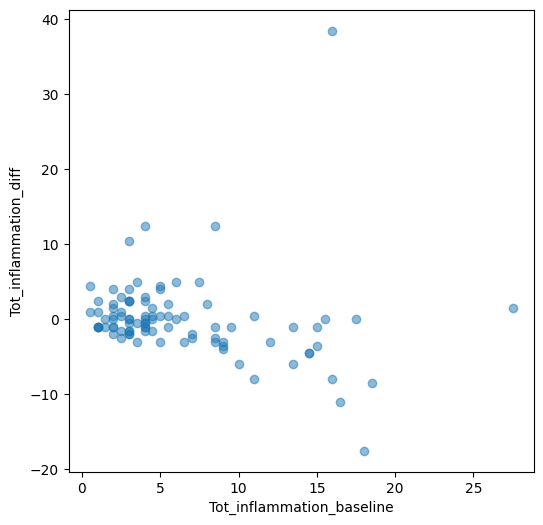

In [49]:
# 提取 x 和 y 列
x = filtered_df['Tot_inflammation_baseline']
y = filtered_df['Tot_inflammation_diff']
slope, intercept, r_value, p_value, std_err = linregress(x, y) # 计算线性回归
filtered_df['Tot_inflammation_diff_pred'] = slope * x + intercept  # 计算预测值
R = np.corrcoef(x, y)[0, 1]  # 计算皮尔逊相关系数
print('slope, intercept, r_value, p_value, std_err', slope, intercept, r_value, p_value, std_err)
# 绘制散点图和回归线
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5)

plt.xlabel('Tot_inflammation_baseline')
plt.ylabel('Tot_inflammation_diff')

plt.show()

/tmp/ipykernel_194984/2768234099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)
/tmp/ipykernel_194984/2768234099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tot_inflammation_diff_pred_bin'] = np.where(filtered_df['Tot_inflammation_diff_pred'] < threshold_pred, 0, 1)


混淆矩阵：
 [[ 0 12]
 [ 1 80]]


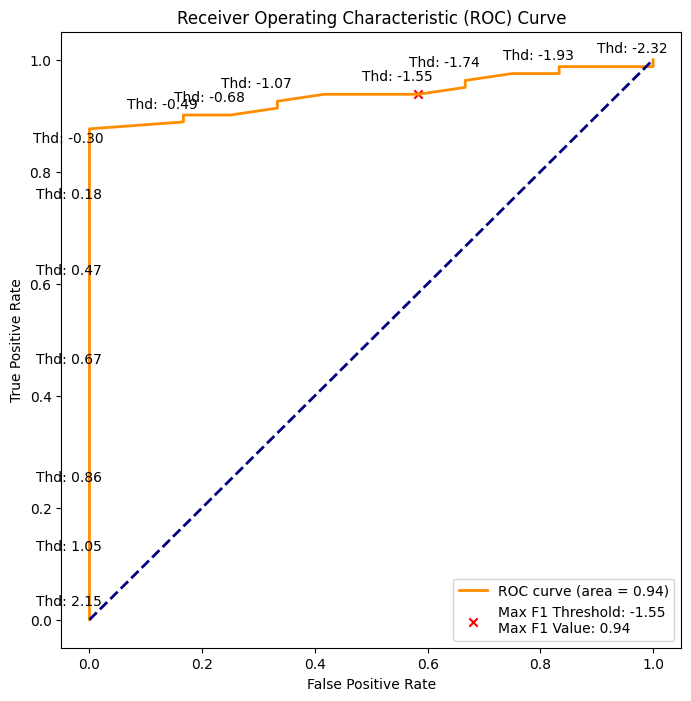

AUC 值：0.94


In [50]:
# 1. 创建 Tot_inflammation_baseline_bin 列
threshold_baseline = -3.12
filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)

# 2. 创建 Tot_inflammation_pred_bin 列
threshold_pred = -3.12
filtered_df['Tot_inflammation_diff_pred_bin'] = np.where(filtered_df['Tot_inflammation_diff_pred'] < threshold_pred, 0, 1)

# 3. 计算混淆矩阵
conf_matrix_baseline = confusion_matrix(filtered_df['Tot_inflammation_diff_bin'], filtered_df['Tot_inflammation_diff_pred_bin'])
print("混淆矩阵：\n", conf_matrix_baseline)

# 4. 计算 ROC 曲线和 AUC 值
fpr, tpr, thresholds = roc_curve(filtered_df['Tot_inflammation_diff_bin'], filtered_df['Tot_inflammation_diff_pred'])
roc_auc = auc(fpr, tpr)

# 找到最大 F1 值对应的 threshold
f1_values = [f1_score(filtered_df['Tot_inflammation_diff_bin'], filtered_df['Tot_inflammation_diff_pred'] > t) for t in thresholds]
max_f1_index = np.argmax(f1_values)
max_f1_threshold = thresholds[max_f1_index]
max_f1_value = f1_values[max_f1_index]


# 绘制 ROC 曲线
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# 标注部分点对应的 threshold
for i in range(0, len(thresholds), len(thresholds) // 10):
    plt.annotate(f'Thd: {thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(-15, 10), ha='center')

# 标注最大 F1 值对应的 threshold 和 F1 值
plt.scatter(fpr[max_f1_index], tpr[max_f1_index], c='red', marker='x', label=f'Max F1 Threshold: {max_f1_threshold:.2f}\nMax F1 Value: {max_f1_value:.2f}')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 打印 AUC 值
print("AUC 值：{:.2f}".format(roc_auc))

/tmp/ipykernel_194984/2565890604.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)
/tmp/ipykernel_194984/2565890604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tot_inflammation_diff_pred_fold'] = np.nan
/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

(46,) (46,)
slope_train, intercept_train, r_value_train, slope2_train, intercept2_train -0.025087517067423265 0.5334521495382758 -0.018321225508131603 -0.025087517067423185 0.5334521495382755
----start training ... ----
(46,) (46,)
confusion_matrix [[ 0  5]
 [ 0 41]]
ROC AUC 值：0.94，最大 F1 值：0.94 (对应的 Threshold：-3.12)
----end training ... ----
(47,) (47,)
slope_test, intercept_test, r_value_test -0.3766590748448912 1.9633236472158955 -0.5233803105753911
confusion_matrix [[ 0  7]
 [ 0 40]]


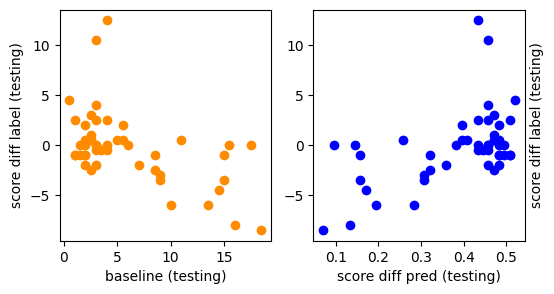

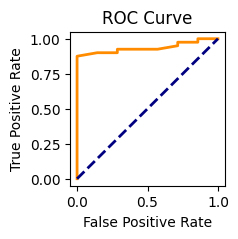

(47,) (47,)
slope_train, intercept_train, r_value_train, slope2_train, intercept2_train -0.3766590748448912 1.9633236472158955 -0.5233803105753911 -0.376659074844891 1.9633236472158935
----start training ... ----
(47,) (47,)
confusion_matrix [[ 5  2]
 [ 3 37]]
ROC AUC 值：0.94，最大 F1 值：0.94 (对应的 Threshold：-3.12)
----end training ... ----
(46,) (46,)
slope_test, intercept_test, r_value_test -0.025087517067423265 0.5334521495382758 -0.018321225508131603
confusion_matrix [[ 3  2]
 [ 3 38]]


/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/jjia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


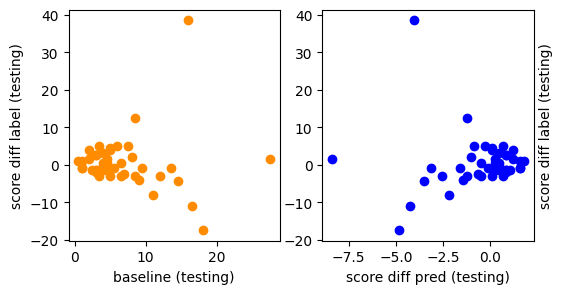

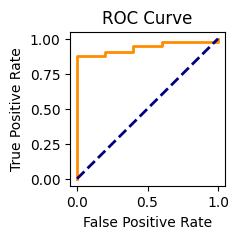

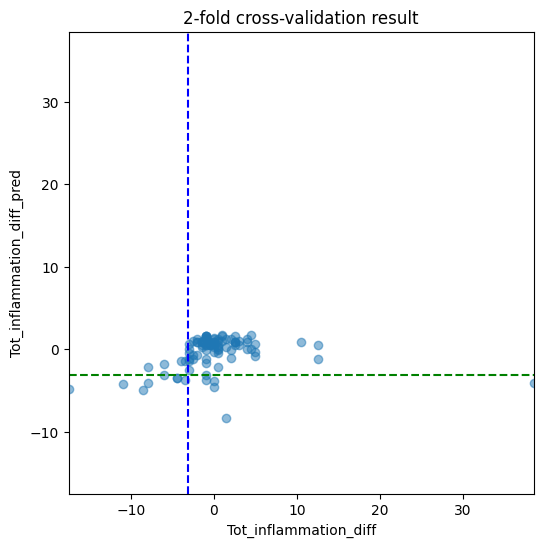


平均 ROC AUC 值：0.94
平均最大 F1 值：0.93


In [60]:
# 创建 Tot_inflammation_baseline_bin 列
threshold_baseline = -3.12
filtered_df['Tot_inflammation_diff_bin'] = np.where(filtered_df['Tot_inflammation_diff'] < threshold_baseline, 0, 1)

# 新增一列用于存储预测值
filtered_df['Tot_inflammation_diff_pred_fold'] = np.nan

# 分成4折
folds = 2
kf = KFold(n_splits=folds, shuffle=True, random_state=711)

# 存储每折的结果
roc_auc_list = []
roc_auc_list_train = []
max_f1_values = []
max_f1_values_train = []

for train_index, test_index in kf.split(filtered_df):
    train_data = filtered_df.iloc[train_index]
    test_data = filtered_df.iloc[test_index]

    # 训练模型（使用线性回归，你也可以替换为其他模型）
    x_train = train_data['Tot_inflammation_baseline']
    y_train = train_data['Tot_inflammation_diff']
    print(x_train.shape, y_train.shape)
  
    
    model = np.polyfit(x_train.squeeze(), y_train, 1)
    slope, intercept, r_value, p_value, std_err = linregress(x_train, y_train) # 计算线性回归
    slope2 = model[0]
    intercept2 = model[1]
    print('slope_train, intercept_train, r_value_train, slope2_train, intercept2_train', slope, intercept, r_value, slope2, intercept2)

    # 在训练集上进行预测
    print('----start training ... ----')
    print(x_train.shape, y_train.shape)

    y_pred = np.polyval(model, x_train.squeeze())
    # 保存预测值到 result_df 中
    filtered_df.iloc[train_index, filtered_df.columns.get_loc('Tot_inflammation_diff_pred_fold')] = y_pred

    # 计算 ROC 曲线和 AUC 值
    fpr, tpr, thresholds = roc_curve(train_data['Tot_inflammation_diff_bin'], y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc_list_train.append(roc_auc)


    matrix = confusion_matrix(train_data['Tot_inflammation_diff_bin'], y_pred > threshold_baseline)
    print('confusion_matrix', matrix)
    f1= f1_score(train_data['Tot_inflammation_diff_bin'], y_pred > threshold_baseline)
    max_f1_values_train.append(f1)

    # 打印每折的结果
    print("ROC AUC 值：{:.2f}，最大 F1 值：{:.2f} (对应的 Threshold：{:.2f})".format(roc_auc, f1, threshold_baseline))
    print('----end training ... ----')

    
    
    # 在测试集上进行预测

    x_test = test_data[['Tot_inflammation_baseline']].squeeze()
    y_test = test_data['Tot_inflammation_diff']
    
    print(x_test.shape, y_test.shape)
    slope, intercept, r_value, p_value, std_err = linregress(x_test, y_test) # 计算线性回归
    print('slope_test, intercept_test, r_value_test', slope, intercept, r_value)


    y_pred = np.polyval(model, x_test.squeeze())
    # 保存预测值到 result_df 中
    # filtered_df.loc[test_index, 'Tot_inflammation_diff_pred_fold'] = y_pred
    filtered_df.iloc[test_index, filtered_df.columns.get_loc('Tot_inflammation_diff_pred_fold')] = y_pred

    # 计算 ROC 曲线和 AUC 值
    fpr, tpr, thresholds = roc_curve(test_data['Tot_inflammation_diff_bin'], y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    # 找到最大 F1 值对应的 threshold
    # f1_values = [f1_score(test_data['Tot_inflammation_diff_bin'], y_pred > t) for t in thresholds]
    # max_f1_index = np.argmax(f1_values)
    # max_f1_value = f1_values[max_f1_index]
    # max_f1_threshold = thresholds[max_f1_index]
    matrix = confusion_matrix(test_data['Tot_inflammation_diff_bin'], y_pred > threshold_baseline)
    print('confusion_matrix', matrix)

    f1= f1_score(test_data['Tot_inflammation_diff_bin'], y_pred > threshold_baseline)
    max_f1_values.append(f1)

    # 打印每折的结果
   
    # 绘制 预测散点图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.scatter(x_test, y_test, color='darkorange')
    ax1.set_xlabel('baseline (validation data)')
    ax1.set_ylabel('score diff label (validation data)')
    ax2.scatter(y_pred, y_test, color='blue')
    ax2.yaxis.set_label_position('right')
    ax2.set_ylabel('score diff label (validation data)')
    ax2.set_xlabel('score diff pred (validation data)')    
    plt.show()
    
    # 绘制 ROC 曲线
    plt.figure(figsize=(2, 2))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='(area = {:.2f})'.format(roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    # plt.legend(loc='lower right')
    plt.show()

# 绘制散点图和回归线
plt.figure(figsize=(6, 6))
plt.scatter(filtered_df['Tot_inflammation_diff'], filtered_df['Tot_inflammation_diff_pred_fold'], label='实际值', alpha=0.5)
# 绘制横线y=-3.12
plt.axhline(y=threshold_baseline, color='green', linestyle='--', label='y = -3.12')

# 绘制竖线x=-3.12
plt.axvline(x=threshold_baseline, color='blue', linestyle='--', label='x = -3.12')


# plt.scatter(filtered_df['Tot_inflammation_baseline'], filtered_df['Tot_inflammation_diff_pred_fold'], label='预测值', alpha=0.5)
# plt.plot(filtered_df['Tot_inflammation_baseline'], filtered_df['Tot_inflammation_diff_pred_fold'], label='回归线', color='red', linewidth=2)
plt.xlabel('Tot_inflammation_diff')
plt.ylabel('Tot_inflammation_diff_pred')
plt.title(f'{folds}-fold cross-validation result')
# plt.legend()
# 设置 x 和 y 轴上下限相同
max_limit = max(filtered_df['Tot_inflammation_diff'].max(), filtered_df['Tot_inflammation_diff_pred_fold'].max())
min_limit = min(filtered_df['Tot_inflammation_diff'].min(), filtered_df['Tot_inflammation_diff_pred_fold'].min())
plt.xlim(min_limit, max_limit)
plt.ylim(min_limit, max_limit)
plt.show()

# 打印平均结果
print("\n平均 ROC AUC 值：{:.2f}".format(np.mean(roc_auc_list)))
print("平均最大 F1 值：{:.2f}".format(np.mean(max_f1_values)))